In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # plotting
%matplotlib inline

## Data source

commits.csv contains information about the Linux kernel commits from 2013-01-01 until relase v5.2.9. The data is compiled with the Gitlog Analyzer available at https://github.com/xypron/gitlog_analyzer.

In [2]:
commits = pd.read_csv('commits.csv')
commits.shape

(454921, 167)

In [3]:
pd.set_option('display.max_columns', 500)
commits.head()

,hash,committer_timestamp,committer_wday,committer_hour,author_timestamp,author_wday,author_hour,commit_message_lines,signed_offs,testeds,reviews,fixes,changed_files,hunks,lines_added,lines_removed,fixed,author_id,author_email_domain,author_commits,author_committer_hour_00,author_committer_hour_01,author_committer_hour_02,author_committer_hour_03,author_committer_hour_04,author_committer_hour_05,author_committer_hour_06,author_committer_hour_07,author_committer_hour_08,author_committer_hour_09,author_committer_hour_10,author_committer_hour_11,author_committer_hour_12,author_committer_hour_13,author_committer_hour_14,author_committer_hour_15,author_committer_hour_16,author_committer_hour_17,author_committer_hour_18,author_committer_hour_19,author_committer_hour_20,author_committer_hour_21,author_committer_hour_22,author_committer_hour_23,author_committer_wday_1,author_committer_wday_2,author_committer_wday_3,author_committer_wday_4,author_committer_wday_5,author_committer_wday_6,author_committer_wday_7,author_first_commit,author_last_commit,author_patches,author_author_hour_00,author_author_hour_01,author_author_hour_02,author_author_hour_03,author_author_hour_04,author_author_hour_05,author_author_hour_06,author_author_hour_07,author_author_hour_08,author_author_hour_09,author_author_hour_10,author_author_hour_11,author_author_hour_12,author_author_hour_13,author_author_hour_14,author_author_hour_15,author_author_hour_16,author_author_hour_17,author_author_hour_18,author_author_hour_19,author_author_hour_20,author_author_hour_21,author_author_hour_22,author_author_hour_23,author_author_wday_1,author_author_wday_2,author_author_wday_3,author_author_wday_4,author_author_wday_5,author_author_wday_6,author_author_wday_7,author_first_patch,author_last_patch,author_commit_message_lines,author_changed_files,author_hunks,author_lines_added,author_lines_removed,committer_id,committer_email_domain,committer_commits,committer_committer_hour_00,committer_committer_hour_01,committer_committer_hour_02,committer_committer_hour_03,committer_committer_hour_04,committer_committer_hour_05,committer_committer_hour_06,committer_committer_hour_07,committer_committer_hour_08,committer_committer_hour_09,committer_committer_hour_10,committer_committer_hour_11,committer_committer_hour_12,committer_committer_hour_13,committer_committer_hour_14,committer_committer_hour_15,committer_committer_hour_16,committer_committer_hour_17,committer_committer_hour_18,committer_committer_hour_19,committer_committer_hour_20,committer_committer_hour_21,committer_committer_hour_22,committer_committer_hour_23,committer_committer_wday_1,committer_committer_wday_2,committer_committer_wday_3,committer_committer_wday_4,committer_committer_wday_5,committer_committer_wday_6,committer_committer_wday_7,committer_first_commit,committer_last_commit,committer_patches,committer_author_hour_00,committer_author_hour_01,committer_author_hour_02,committer_author_hour_03,committer_author_hour_04,committer_author_hour_05,committer_author_hour_06,committer_author_hour_07,committer_author_hour_08,committer_author_hour_09,committer_author_hour_10,committer_author_hour_11,committer_author_hour_12,committer_author_hour_13,committer_author_hour_14,committer_author_hour_15,committer_author_hour_16,committer_author_hour_17,committer_author_hour_18,committer_author_hour_19,committer_author_hour_20,committer_author_hour_21,committer_author_hour_22,committer_author_hour_23,committer_author_wday_1,committer_author_wday_2,committer_author_wday_3,committer_author_wday_4,committer_author_wday_5,committer_author_wday_6,committer_author_wday_7,committer_first_patch,committer_last_patch,committer_commit_message_lines,committer_changed_files,committer_hunks,committer_lines_added,committer_lines_removed
0,e003ae399c160e00c1a882dc6dd4f0ef855ae616,1357041880,2,0,1353669155,5,8,10,2,0,0,0,1,1,2,2,0,10759,gmail.com,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,125,1,0,3,1,1,0,2,9,6,27,4,14,1

In [4]:
print("lines added: {}".format(np.sum(commits['lines_added'])))
print("lines removed: {}".format(np.sum(commits['lines_removed'])))

lines added: 27420276
lines removed: 17278976


In [26]:
# Some patches do not change any line but only file attributes.
commits[commits['hunks']==0].shape[0]

47

## Changes

The Linux kernel v5.2.9 has 26,552,127 lines (https://de.wikipedia.org/wiki/Linux_%28Kernel%29). Since 2013 more lines were deleted than the 2013 kernel contained.

In [5]:
fixed = commits[commits['fixed']>0];
fixed.shape

(22012, 167)

In [6]:
print("Percentage of patches marked as fixed:{:5.2f} %".format(fixed.shape[0] / commits.shape[0] * 100))

Percentage of patches marked as fixed: 4.84 %


## Fixes:

If a patch correct3 an error created by a previuous patch the patch may be marked with

    "Fixes: <hash> ("<commit title>")
    
(https://www.kernel.org/doc/html/v4.17/process/submitting-patches.html#using-reported-by-tested-by-reviewed-by-suggested-by-and-fixes)

If a subsequent patch marks a commit as fixed, we can assume that it contained an error. On the other side a commit not being mentioned as fixed does not imply that it was free of errors:

* an error has not yet been discovered
* an error was discovered but was not (yet) fixed, e.g. a minor issue like using %d to print an unsigned integer
* the author of a fix did not bother to mention the fixed patch
* a patch with a 'Fixes:' message may have an invalid format so that the Gitlog Analyzer does not count it (e.g. the hash is too short). This concerns 757 commits since 2013.

In [7]:
def hist_side_by_side(title, ds1, ds2, bins, min, max):
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), squeeze=False)
    fig.tight_layout()
    fig.suptitle(title, fontsize=28, y=1.1)
    
    ax[0][0].title.set_text('All commits')
    ax[0][1].title.set_text('Fixed commits')
    
    ds1.hist(bins=bins, range=(min, max), ax=ax[0][0])
    ds2.hist(bins=bins, range=(min, max), ax=ax[0][1])

    plt.show()

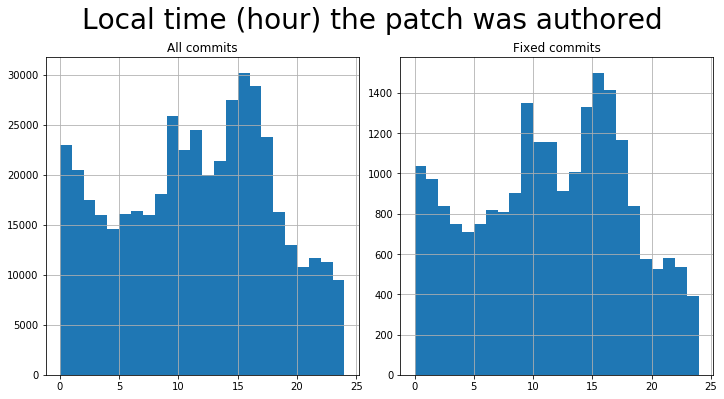

In [8]:
hist_side_by_side('Local time (hour) the patch was authored', commits['author_hour'], fixed['author_hour'], 24, 0, 24)

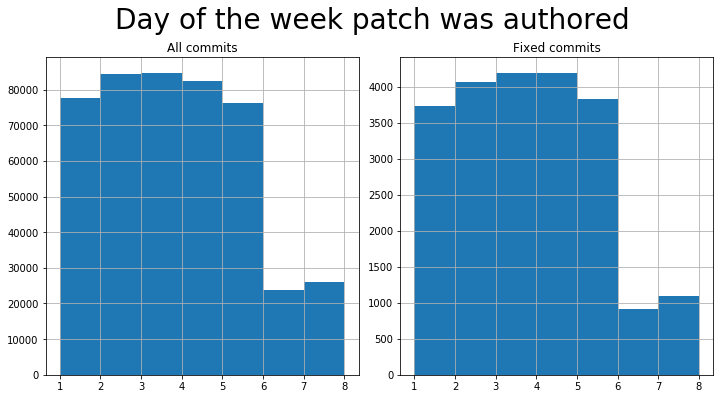

In [9]:
hist_side_by_side('Day of the week patch was authored', commits['author_wday'], fixed['author_wday'], 7, 1, 8)

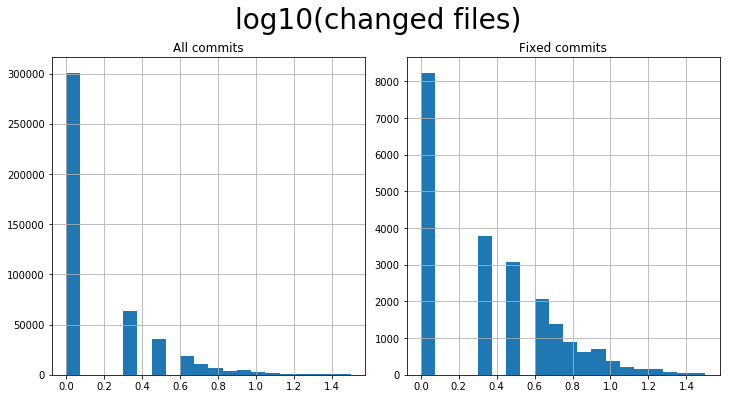

mean number of changed files:
all: 2.2306246579076365
fixed: 3.929129565691441


In [10]:
hist_side_by_side('log10(changed files)',
                  np.log10(commits['changed_files']), np.log10(fixed['changed_files']),
                  20, 0, 1.5)
print("mean number of changed files:\nall: {}\nfixed: {}".format(
      np.mean(commits[commits['changed_files']>0]['changed_files']),
      np.mean(fixed[fixed['changed_files']>0]['changed_files'])))

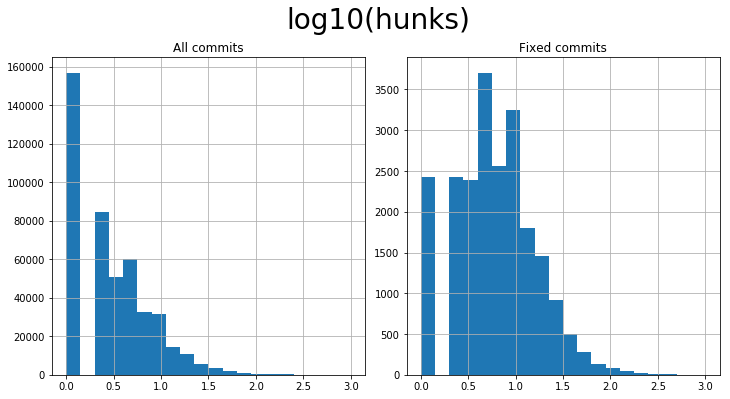

mean number of hunks:
all: 5.20612960951824
fixed: 10.389514810103579


In [11]:
hist_side_by_side('log10(hunks)',
                  np.log10(commits[commits['hunks']>0]['hunks']),
                  np.log10(fixed[fixed['hunks']>0]['hunks']),
                  20, 0, 3)
print("mean number of hunks:\nall: {}\nfixed: {}".format(
      np.mean(commits[commits['hunks']>0]['hunks']),
      np.mean(fixed[fixed['hunks']>0]['hunks'])))

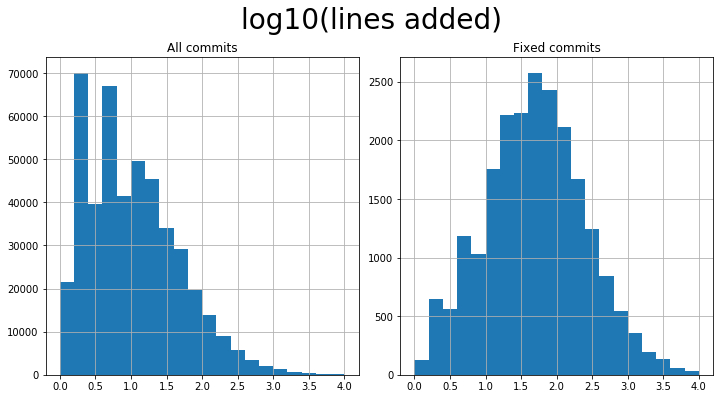

In [12]:
hist_side_by_side('log10(lines added)',
                  np.log10(commits[commits['lines_added']>0]['lines_added']),
                  np.log10(fixed[fixed['lines_added']>0]['lines_added']),
                  20, 0, 4)

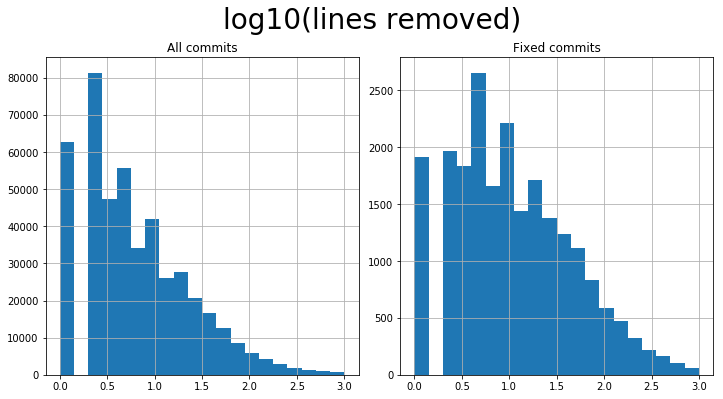

mean number of lines removed:
all: 37.98629070907548
fixed: 67.57759403961475


In [13]:
hist_side_by_side('log10(lines removed)',
                  np.log10(commits[commits['lines_removed']>0]['lines_removed']),
                  np.log10(fixed[fixed['lines_removed']>0]['lines_removed']),
                  20, 0, 3)
print("mean number of lines removed:\nall: {}\nfixed: {}".format(
      np.mean(commits[commits['lines_removed']>0]['lines_removed']),
      np.mean(fixed[fixed['lines_removed']>0]['lines_removed'])))

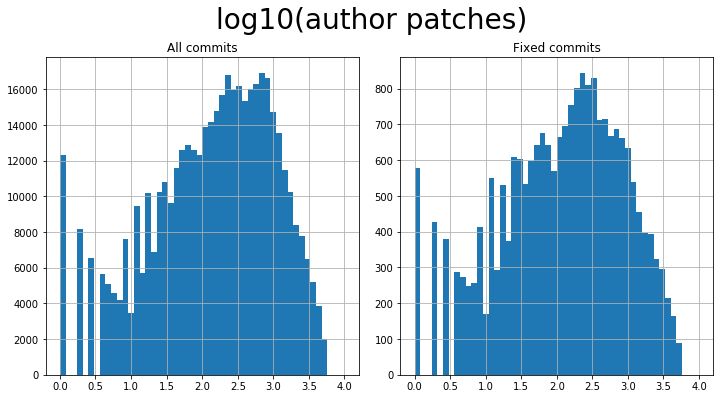

mean number of author patches:
all: 538.1464166305798
fixed: 480.80228966018535


In [14]:
hist_side_by_side('log10(author patches)',
                  np.log10(commits[commits['author_patches']>0]['author_patches']),
                  np.log10(fixed[fixed['author_patches']>0]['author_patches']),
                  50, 0, 4)
print("mean number of author patches:\nall: {}\nfixed: {}".format(
      np.mean(commits[commits['author_patches']>0]['author_patches']),
      np.mean(fixed[fixed['author_patches']>0]['author_patches'])))

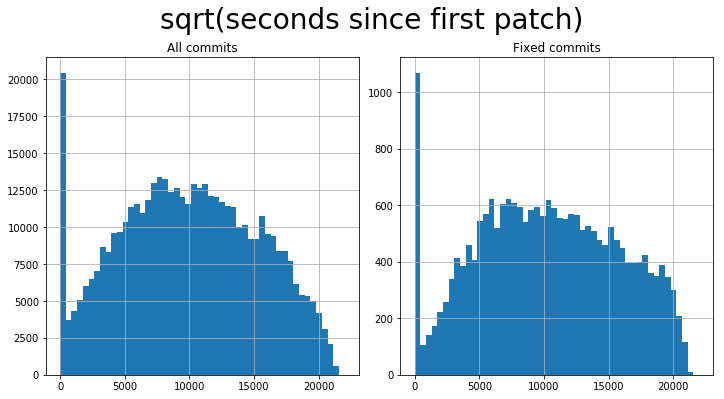

mean years since first patch:
all: 4.04
fixed: 4.28


In [18]:
hist_side_by_side('sqrt(seconds since first patch)',
                  np.sqrt(commits['author_last_patch'] - commits['author_first_patch']),
                  np.sqrt(fixed['author_last_patch'] - fixed['author_first_patch']),
                  50, 0, 22000)
print("mean years since first patch:\nall: {:4.2f}\nfixed: {:4.2f}".format(
      np.mean(commits['author_last_patch'] - commits['author_first_patch']) / 31557600,
      np.mean(fixed['author_last_patch'] - fixed['author_first_patch']) / 31557600))

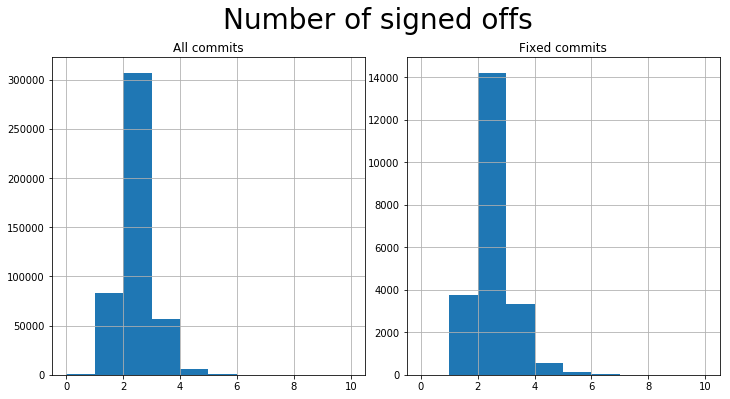

mean number of signed offs:
all: 1.97
fixed: 2.06


In [33]:
hist_side_by_side('Number of signed offs',
                  commits['signed_offs'], fixed['signed_offs'],
                  10, 0, 10)
print("mean number of signed offs:\nall: {:4.2f}\nfixed: {:4.2f}".format(
      np.mean(commits['signed_offs']), np.mean(fixed['signed_offs'])))

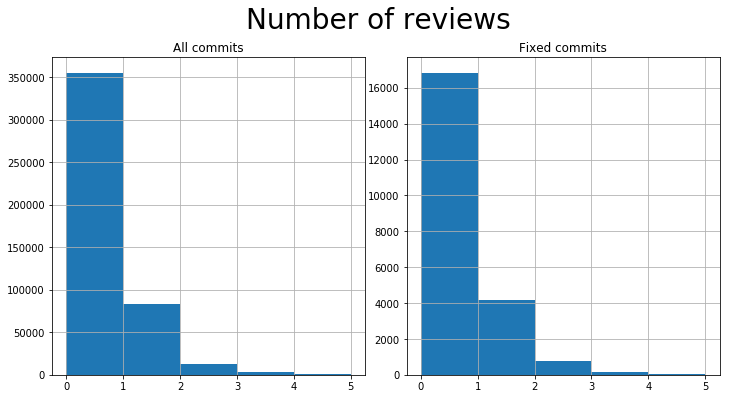

mean number of reviews:
all: 0.27
fixed: 0.29


In [35]:
hist_side_by_side('Number of reviews',
                  commits['reviews'], fixed['reviews'],
                  5, 0, 5)
print("mean number of reviews:\nall: {:4.2f}\nfixed: {:4.2f}".format(
      np.mean(commits['reviews']), np.mean(fixed['reviews'])))

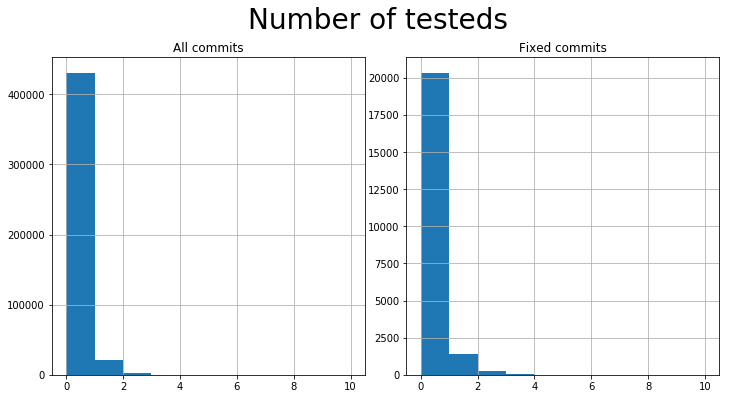

mean number of testeds:
all: 0.06
fixed: 0.09


In [36]:
hist_side_by_side('Number of testeds',
                  commits['testeds'], fixed['testeds'],
                  10, 0, 10)
print("mean number of testeds:\nall: {:4.2f}\nfixed: {:4.2f}".format(
      np.mean(commits['testeds']), np.mean(fixed['testeds'])))